# Pipeline Integrado - Economiza+ MVP

**Sprint 2 - Dia 12**  
**Objetivo:** Criar pipeline end-to-end que integra todos os componentes do sistema

**Pipeline:**
1. Entrada: dados de um usuário
2. Normalizar features (scaler.pkl)
3. Classificar em cluster (kmeans_best.pkl)
4. Gerar 2 recomendações (recomendacoes_regras.json)
5. Detectar anomalias nas transações (isolation_forest.pkl)
6. Saída: perfil completo + recomendações + alertas

**Entregáveis:**
- Função `analisar_usuario(user_id)`
- Classe `EconomizaPipeline`
- Testes com 10 usuários de diferentes clusters
- `models/pipeline_completo.pkl`

## 1. Setup e Carregamento de Artefatos

In [1]:
import pandas as pd
import numpy as np
import json
import joblib
from datetime import datetime
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ECONOMIZA+ MVP - PIPELINE INTEGRADO")
print("="*70)
print(f"\nData: {datetime.now().strftime('%d/%m/%Y %H:%M')}")

ECONOMIZA+ MVP - PIPELINE INTEGRADO

Data: 29/01/2026 20:19


In [2]:
# Carregar todos os artefatos necessários
print("\nCarregando artefatos...")

# 1. Modelo de clustering
kmeans_model = joblib.load('../models/kmeans_best.pkl')
print("  [OK] kmeans_best.pkl")

# 2. Scaler para clustering
scaler_clustering = joblib.load('../models/scaler.pkl')
print("  [OK] scaler.pkl")

# 3. Regras de recomendação
with open('../models/recomendacoes_regras.json', 'r', encoding='utf-8') as f:
    regras_recomendacao = json.load(f)
print("  [OK] recomendacoes_regras.json")

# 4. Modelo de detecção de anomalias
isolation_forest = joblib.load('../models/isolation_forest.pkl')
print("  [OK] isolation_forest.pkl")

# 5. Scaler para anomalias
scaler_anomalias = joblib.load('../models/scaler_anomalias.pkl')
print("  [OK] scaler_anomalias.pkl")

# 6. Estatísticas por categoria (para anomalias)
stats_categoria = pd.read_csv('../models/stats_categoria_anomalias.csv')
print("  [OK] stats_categoria_anomalias.csv")

# 7. Dados dos usuários e transações
usuarios = pd.read_csv('../data/raw/usuarios.csv')
transacoes = pd.read_csv('../data/raw/transacoes.csv')
usuarios_clustered = pd.read_csv('../data/processed/usuarios_clustered.csv')
print("  [OK] Dados carregados")

print(f"\nTotal de artefatos carregados: 7")


Carregando artefatos...
  [OK] kmeans_best.pkl
  [OK] scaler.pkl
  [OK] recomendacoes_regras.json
  [OK] isolation_forest.pkl
  [OK] scaler_anomalias.pkl
  [OK] stats_categoria_anomalias.csv
  [OK] Dados carregados

Total de artefatos carregados: 7


## 2. Definição dos Nomes dos Clusters

In [3]:
# Mapeamento de clusters
CLUSTER_NAMES = {
    0: "Endividados Severos",
    1: "Em Alerta",
    2: "Endividados Moderados",
    3: "Poupadores"
}

CLUSTER_PRIORIDADES = {
    0: "CRÍTICA",
    1: "MODERADA",
    2: "ALTA",
    3: "BAIXA"
}

CLUSTER_CORES = {
    0: "#d62728",  # Vermelho
    1: "#ff7f0e",  # Laranja
    2: "#9467bd",  # Roxo
    3: "#2ca02c"   # Verde
}

# Features usadas no clustering
FEATURES_CLUSTERING = ['media_renda', 'media_gasto', 'taxa_poupanca', 'pct_gastos_essenciais', 'std_gasto']

print("Clusters configurados:")
for k, v in CLUSTER_NAMES.items():
    print(f"  Cluster {k}: {v} (Prioridade: {CLUSTER_PRIORIDADES[k]})")

Clusters configurados:
  Cluster 0: Endividados Severos (Prioridade: CRÍTICA)
  Cluster 1: Em Alerta (Prioridade: MODERADA)
  Cluster 2: Endividados Moderados (Prioridade: ALTA)
  Cluster 3: Poupadores (Prioridade: BAIXA)


## 3. Classe EconomizaPipeline

In [4]:
class EconomizaPipeline:
    """
    Pipeline integrado do Economiza+ MVP.
    
    Componentes:
    - Classificação de perfil (K-means)
    - Geração de recomendações (regras por cluster)
    - Detecção de anomalias (Isolation Forest)
    """
    
    def __init__(self, kmeans_model, scaler_clustering, regras_recomendacao,
                 isolation_forest, scaler_anomalias, stats_categoria):
        """
        Inicializa o pipeline com todos os modelos e configurações.
        """
        self.kmeans = kmeans_model
        self.scaler_clustering = scaler_clustering
        self.regras = regras_recomendacao
        self.isolation_forest = isolation_forest
        self.scaler_anomalias = scaler_anomalias
        self.stats_categoria = stats_categoria
        
        self.cluster_names = CLUSTER_NAMES
        self.cluster_prioridades = CLUSTER_PRIORIDADES
        self.features_clustering = FEATURES_CLUSTERING
        
    def calcular_features_usuario(self, transacoes_usuario: pd.DataFrame) -> Dict:
        """
        Calcula as 5 features de clustering a partir das transações do usuário.
        """
        # Separar renda e gastos
        renda = transacoes_usuario[transacoes_usuario['categoria'] == 'Renda']['valor']
        gastos = transacoes_usuario[transacoes_usuario['categoria'] != 'Renda']
        
        # Calcular features
        media_renda = renda.sum() / transacoes_usuario['mes'].nunique() if len(renda) > 0 else 0
        media_gasto = gastos['valor'].sum() / transacoes_usuario['mes'].nunique() if len(gastos) > 0 else 0
        
        taxa_poupanca = (media_renda - media_gasto) / media_renda if media_renda > 0 else 0
        
        gastos_essenciais = gastos[gastos['is_essencial'] == True]['valor'].sum()
        pct_gastos_essenciais = gastos_essenciais / gastos['valor'].sum() if gastos['valor'].sum() > 0 else 0
        
        # Variabilidade mensal
        gastos_mensais = gastos.groupby('mes')['valor'].sum()
        std_gasto = gastos_mensais.std() if len(gastos_mensais) > 1 else 0
        
        return {
            'media_renda': media_renda,
            'media_gasto': media_gasto,
            'taxa_poupanca': taxa_poupanca,
            'pct_gastos_essenciais': pct_gastos_essenciais,
            'std_gasto': std_gasto
        }
    
    def classificar_cluster(self, features: Dict) -> Dict:
        """
        Classifica o usuário em um cluster com base nas features.
        """
        # Preparar array de features na ordem correta
        X = np.array([[features[f] for f in self.features_clustering]])
        
        # Normalizar
        X_scaled = self.scaler_clustering.transform(X)
        
        # Predizer cluster
        cluster = self.kmeans.predict(X_scaled)[0]
        
        # Calcular distância ao centroide (confiança)
        distancias = self.kmeans.transform(X_scaled)[0]
        distancia_cluster = distancias[cluster]
        confianca = 1 / (1 + distancia_cluster)  # Quanto menor a distância, maior a confiança
        
        return {
            'cluster': int(cluster),
            'cluster_nome': self.cluster_names[cluster],
            'prioridade': self.cluster_prioridades[cluster],
            'confianca': round(confianca, 4),
            'distancia_centroide': round(distancia_cluster, 4)
        }
    
    def gerar_recomendacoes(self, cluster: int, transacoes_usuario: pd.DataFrame) -> List[Dict]:
        """
        Gera as 2 recomendações personalizadas para o cluster do usuário.
        """
        cluster_str = str(cluster)
        regras_cluster = self.regras['clusters'][cluster_str]['regras']
        
        recomendacoes = []
        gastos = transacoes_usuario[transacoes_usuario['categoria'] != 'Renda']
        
        for regra in regras_cluster:
            categoria = regra['categoria']
            
            # Calcular gasto atual na categoria
            gasto_cat = gastos[gastos['categoria'] == categoria]['valor'].sum()
            gasto_mensal = gasto_cat / transacoes_usuario['mes'].nunique() if transacoes_usuario['mes'].nunique() > 0 else 0
            
            # Calcular economia potencial
            economia = gasto_mensal * regra['percentual']
            
            recomendacoes.append({
                'id': regra['id'],
                'titulo': regra['titulo'],
                'categoria': categoria,
                'mensagem': regra['mensagem'],
                'dica': regra['dica'],
                'acao': regra['acao'],
                'gasto_atual': round(gasto_mensal, 2),
                'economia_potencial': round(economia, 2),
                'percentual_reducao': f"{regra['percentual']*100:.0f}%"
            })
        
        return recomendacoes
    
    def detectar_anomalias(self, transacoes_usuario: pd.DataFrame, top_n: int = 5) -> Dict:
        """
        Detecta transações anômalas nas transações do usuário.
        """
        gastos = transacoes_usuario[transacoes_usuario['categoria'] != 'Renda'].copy()
        
        if len(gastos) == 0:
            return {'total_anomalias': 0, 'transacoes_anomalas': [], 'pct_anomalias': 0}
        
        # Merge com estatísticas de categoria
        gastos = gastos.merge(self.stats_categoria, on='categoria', how='left')
        
        # Preencher valores faltantes com médias gerais
        gastos['media_cat'] = gastos['media_cat'].fillna(self.stats_categoria['media_cat'].mean())
        gastos['std_cat'] = gastos['std_cat'].fillna(self.stats_categoria['std_cat'].mean())
        gastos['mediana_cat'] = gastos['mediana_cat'].fillna(self.stats_categoria['mediana_cat'].mean())
        
        # Calcular features
        gastos['feat_valor_norm'] = (gastos['valor'] - gastos['media_cat']) / gastos['std_cat']
        gastos['feat_ratio_mediana'] = gastos['valor'] / gastos['mediana_cat']
        
        # Tratar infinitos/NaN
        gastos['feat_valor_norm'] = gastos['feat_valor_norm'].replace([np.inf, -np.inf], 0).fillna(0)
        gastos['feat_ratio_mediana'] = gastos['feat_ratio_mediana'].replace([np.inf, -np.inf], 0).fillna(0)
        
        # Preparar features para predição
        X = gastos[['feat_valor_norm', 'feat_ratio_mediana']].values
        X_scaled = self.scaler_anomalias.transform(X)
        
        # Predição
        pred = self.isolation_forest.predict(X_scaled)
        scores = self.isolation_forest.decision_function(X_scaled)
        
        gastos['is_anomalia_pred'] = (pred == -1)
        gastos['anomaly_score'] = scores
        
        # Filtrar anomalias
        anomalias = gastos[gastos['is_anomalia_pred'] == True].copy()
        anomalias = anomalias.sort_values('anomaly_score').head(top_n)
        
        transacoes_anomalas = []
        for _, row in anomalias.iterrows():
            transacoes_anomalas.append({
                'data': row['data'],
                'categoria': row['categoria'],
                'valor': round(row['valor'], 2),
                'score': round(row['anomaly_score'], 4),
                'severidade': 'ALTA' if row['anomaly_score'] < -0.1 else 'MEDIA' if row['anomaly_score'] < 0 else 'BAIXA'
            })
        
        return {
            'total_anomalias': int(gastos['is_anomalia_pred'].sum()),
            'total_transacoes': len(gastos),
            'pct_anomalias': round(gastos['is_anomalia_pred'].mean() * 100, 2),
            'transacoes_anomalas': transacoes_anomalas
        }
    
    def analisar_usuario(self, user_id: str, transacoes_df: pd.DataFrame, 
                         features_precalculadas: Dict = None) -> Dict:
        """
        Análise completa de um usuário.
        
        Retorna perfil completo com:
        - Classificação de cluster
        - Features financeiras
        - Recomendações personalizadas
        - Detecção de anomalias
        - Resumo executivo
        """
        # Filtrar transações do usuário
        transacoes_usuario = transacoes_df[transacoes_df['user_id'] == user_id].copy()
        
        if len(transacoes_usuario) == 0:
            return {'erro': f'Usuário {user_id} não encontrado'}
        
        # 1. Calcular features (ou usar pré-calculadas)
        if features_precalculadas:
            features = features_precalculadas
        else:
            features = self.calcular_features_usuario(transacoes_usuario)
        
        # 2. Classificar cluster
        classificacao = self.classificar_cluster(features)
        
        # 3. Gerar recomendações
        recomendacoes = self.gerar_recomendacoes(classificacao['cluster'], transacoes_usuario)
        
        # 4. Detectar anomalias
        anomalias = self.detectar_anomalias(transacoes_usuario)
        
        # 5. Calcular economia total potencial
        economia_total = sum(r['economia_potencial'] for r in recomendacoes)
        pct_economia_renda = (economia_total / features['media_renda'] * 100) if features['media_renda'] > 0 else 0
        
        # 6. Montar resultado completo
        resultado = {
            'user_id': user_id,
            'data_analise': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            
            'perfil': {
                'cluster': classificacao['cluster'],
                'nome': classificacao['cluster_nome'],
                'prioridade': classificacao['prioridade'],
                'confianca': classificacao['confianca']
            },
            
            'financeiro': {
                'renda_media': round(features['media_renda'], 2),
                'gasto_medio': round(features['media_gasto'], 2),
                'taxa_poupanca': round(features['taxa_poupanca'] * 100, 2),
                'pct_essenciais': round(features['pct_gastos_essenciais'] * 100, 2),
                'variabilidade': round(features['std_gasto'], 2)
            },
            
            'recomendacoes': recomendacoes,
            
            'economia': {
                'total_mensal': round(economia_total, 2),
                'pct_da_renda': round(pct_economia_renda, 2),
                'taxa_poupanca_projetada': round((features['taxa_poupanca'] + pct_economia_renda/100) * 100, 2)
            },
            
            'anomalias': anomalias,
            
            'resumo': self._gerar_resumo(classificacao, features, economia_total, anomalias)
        }
        
        return resultado
    
    def _gerar_resumo(self, classificacao: Dict, features: Dict, 
                      economia_total: float, anomalias: Dict) -> str:
        """
        Gera um resumo textual da análise.
        """
        taxa_poup = features['taxa_poupanca'] * 100
        
        if taxa_poup >= 20:
            situacao = "excelente controle financeiro"
        elif taxa_poup >= 0:
            situacao = "finanças equilibradas"
        elif taxa_poup >= -30:
            situacao = "gastos acima da renda - atenção necessária"
        else:
            situacao = "situação crítica - gastos muito acima da renda"
        
        resumo = f"Perfil: {classificacao['cluster_nome']} ({situacao}). "
        resumo += f"Economia potencial: R$ {economia_total:.2f}/mês. "
        
        if anomalias['total_anomalias'] > 0:
            resumo += f"Atenção: {anomalias['total_anomalias']} transação(ões) atípica(s) detectada(s)."
        else:
            resumo += "Nenhuma transação atípica detectada."
        
        return resumo

print("Classe EconomizaPipeline definida!")

Classe EconomizaPipeline definida!


## 4. Instanciar Pipeline

In [5]:
# Criar instância do pipeline
pipeline = EconomizaPipeline(
    kmeans_model=kmeans_model,
    scaler_clustering=scaler_clustering,
    regras_recomendacao=regras_recomendacao,
    isolation_forest=isolation_forest,
    scaler_anomalias=scaler_anomalias,
    stats_categoria=stats_categoria
)

print("Pipeline instanciado com sucesso!")
print(f"\nComponentes:")
print(f"  - Clustering: K-means ({len(CLUSTER_NAMES)} clusters)")
print(f"  - Recomendações: {regras_recomendacao['total_regras']} regras")
print(f"  - Anomalias: Isolation Forest")

Pipeline instanciado com sucesso!

Componentes:
  - Clustering: K-means (4 clusters)
  - Recomendações: 8 regras
  - Anomalias: Isolation Forest


## 5. Função Wrapper Simplificada

In [6]:
def analisar_usuario(user_id: str) -> Dict:
    """
    Função wrapper para análise simplificada de usuário.
    
    Uso:
        resultado = analisar_usuario('user_0001')
    """
    return pipeline.analisar_usuario(user_id, transacoes)

print("Função analisar_usuario() definida!")
print("\nUso: resultado = analisar_usuario('user_0001')")

Função analisar_usuario() definida!

Uso: resultado = analisar_usuario('user_0001')


## 6. Teste Individual

In [7]:
# Testar com um usuário
print("="*70)
print("TESTE: ANÁLISE INDIVIDUAL")
print("="*70)

resultado = analisar_usuario('user_0001')

print(f"\nUsuário: {resultado['user_id']}")
print(f"Data da análise: {resultado['data_analise']}")

print(f"\n--- PERFIL ---")
print(f"Cluster: {resultado['perfil']['cluster']} - {resultado['perfil']['nome']}")
print(f"Prioridade: {resultado['perfil']['prioridade']}")
print(f"Confiança: {resultado['perfil']['confianca']:.2%}")

print(f"\n--- FINANCEIRO ---")
print(f"Renda média: R$ {resultado['financeiro']['renda_media']:,.2f}")
print(f"Gasto médio: R$ {resultado['financeiro']['gasto_medio']:,.2f}")
print(f"Taxa de poupança: {resultado['financeiro']['taxa_poupanca']:.1f}%")

print(f"\n--- RECOMENDAÇÕES ---")
for i, rec in enumerate(resultado['recomendacoes'], 1):
    print(f"\n{i}. {rec['titulo']}")
    print(f"   Categoria: {rec['categoria']}")
    print(f"   Gasto atual: R$ {rec['gasto_atual']:,.2f}/mês")
    print(f"   Economia potencial: R$ {rec['economia_potencial']:,.2f}/mês ({rec['percentual_reducao']})")
    print(f"   Dica: {rec['dica']}")

print(f"\n--- ECONOMIA TOTAL ---")
print(f"Economia mensal projetada: R$ {resultado['economia']['total_mensal']:,.2f}")
print(f"Percentual da renda: {resultado['economia']['pct_da_renda']:.1f}%")
print(f"Taxa de poupança projetada: {resultado['economia']['taxa_poupanca_projetada']:.1f}%")

print(f"\n--- ANOMALIAS ---")
print(f"Transações anômalas: {resultado['anomalias']['total_anomalias']} de {resultado['anomalias']['total_transacoes']}")
if resultado['anomalias']['transacoes_anomalas']:
    print("Top transações atípicas:")
    for a in resultado['anomalias']['transacoes_anomalas'][:3]:
        print(f"   - {a['data']}: {a['categoria']} R$ {a['valor']:,.2f} (Severidade: {a['severidade']})")

print(f"\n--- RESUMO ---")
print(resultado['resumo'])

TESTE: ANÁLISE INDIVIDUAL

Usuário: user_0001
Data da análise: 2026-01-29 20:19:39

--- PERFIL ---
Cluster: 3 - Poupadores
Prioridade: BAIXA
Confiança: 23.46%

--- FINANCEIRO ---
Renda média: R$ 12,252.48
Gasto médio: R$ 3,834.97
Taxa de poupança: 68.7%

--- RECOMENDAÇÕES ---

1. Otimizar gastos com transporte
   Categoria: Transporte
   Gasto atual: R$ 486.08/mês
   Economia potencial: R$ 72.91/mês (15%)
   Dica: Considere caronas, transporte público ou bicicleta para trajetos curtos

2. Revisar planos e assinaturas
   Categoria: Telecomunicacoes
   Gasto atual: R$ 103.30/mês
   Economia potencial: R$ 20.66/mês (20%)
   Dica: Cancele assinaturas não utilizadas e negocie valores com operadoras

--- ECONOMIA TOTAL ---
Economia mensal projetada: R$ 93.57
Percentual da renda: 0.8%
Taxa de poupança projetada: 69.5%

--- ANOMALIAS ---
Transações anômalas: 14 de 392
Top transações atípicas:
   - 2025-11-06: Transporte R$ 676.39 (Severidade: ALTA)
   - 2025-09-08: Educacao R$ 178.92 (Severida

## 7. Teste com 10 Usuários de Diferentes Clusters

In [8]:
# Selecionar usuários representativos de cada cluster
print("="*70)
print("TESTE: 10 USUÁRIOS DE DIFERENTES CLUSTERS")
print("="*70)

# Selecionar 2-3 usuários de cada cluster
usuarios_teste = []
for cluster in range(4):
    users_cluster = usuarios_clustered[usuarios_clustered['cluster'] == cluster]['user_id'].head(3).tolist()
    usuarios_teste.extend(users_cluster[:3 if cluster in [1, 2] else 2])

usuarios_teste = usuarios_teste[:10]  # Garantir 10 usuários

print(f"\nUsuários selecionados: {usuarios_teste}")

TESTE: 10 USUÁRIOS DE DIFERENTES CLUSTERS

Usuários selecionados: ['user_0011', 'user_0013', 'user_0004', 'user_0006', 'user_0007', 'user_0002', 'user_0008', 'user_0029', 'user_0001', 'user_0003']


In [9]:
# Executar análise para todos
resultados_teste = []

for user_id in usuarios_teste:
    resultado = analisar_usuario(user_id)
    resultados_teste.append({
        'user_id': user_id,
        'cluster': resultado['perfil']['cluster'],
        'cluster_nome': resultado['perfil']['nome'],
        'renda_media': resultado['financeiro']['renda_media'],
        'gasto_medio': resultado['financeiro']['gasto_medio'],
        'taxa_poupanca': resultado['financeiro']['taxa_poupanca'],
        'economia_potencial': resultado['economia']['total_mensal'],
        'pct_economia': resultado['economia']['pct_da_renda'],
        'anomalias': resultado['anomalias']['total_anomalias'],
        'resumo': resultado['resumo']
    })

df_teste = pd.DataFrame(resultados_teste)
print("\nResultados da análise:")
print(df_teste[['user_id', 'cluster_nome', 'taxa_poupanca', 'economia_potencial', 'anomalias']].to_string(index=False))


Resultados da análise:
  user_id          cluster_nome  taxa_poupanca  economia_potencial  anomalias
user_0011   Endividados Severos         -59.62              395.11          9
user_0013   Endividados Severos         -59.63              541.70         42
user_0004             Em Alerta         -14.50              168.18         11
user_0006             Em Alerta          31.76              101.40          5
user_0007            Poupadores          47.31               75.86          8
user_0002 Endividados Moderados         -70.76              842.26         28
user_0008   Endividados Severos         -24.69              496.77         26
user_0029            Poupadores          19.02              128.48         28
user_0001            Poupadores          68.70               93.57         14
user_0003            Poupadores          47.00               94.18         11


In [10]:
# Estatísticas por cluster
print("\n" + "="*70)
print("ESTATÍSTICAS POR CLUSTER")
print("="*70)

stats_cluster = df_teste.groupby('cluster_nome').agg({
    'user_id': 'count',
    'taxa_poupanca': 'mean',
    'economia_potencial': 'mean',
    'pct_economia': 'mean',
    'anomalias': 'mean'
}).round(2)

stats_cluster.columns = ['Qtd', 'Taxa Poupança (%)', 'Economia (R$)', '% Economia', 'Anomalias']
print("\n")
print(stats_cluster.to_string())


ESTATÍSTICAS POR CLUSTER


                       Qtd  Taxa Poupança (%)  Economia (R$)  % Economia  Anomalias
cluster_nome                                                                       
Em Alerta                2               8.63         134.79        3.96       8.00
Endividados Moderados    1             -70.76         842.26       20.30      28.00
Endividados Severos      3             -47.98         477.86       13.27      25.67
Poupadores               4              45.51          98.02        1.24      15.25


## 8. Visualização dos Resultados

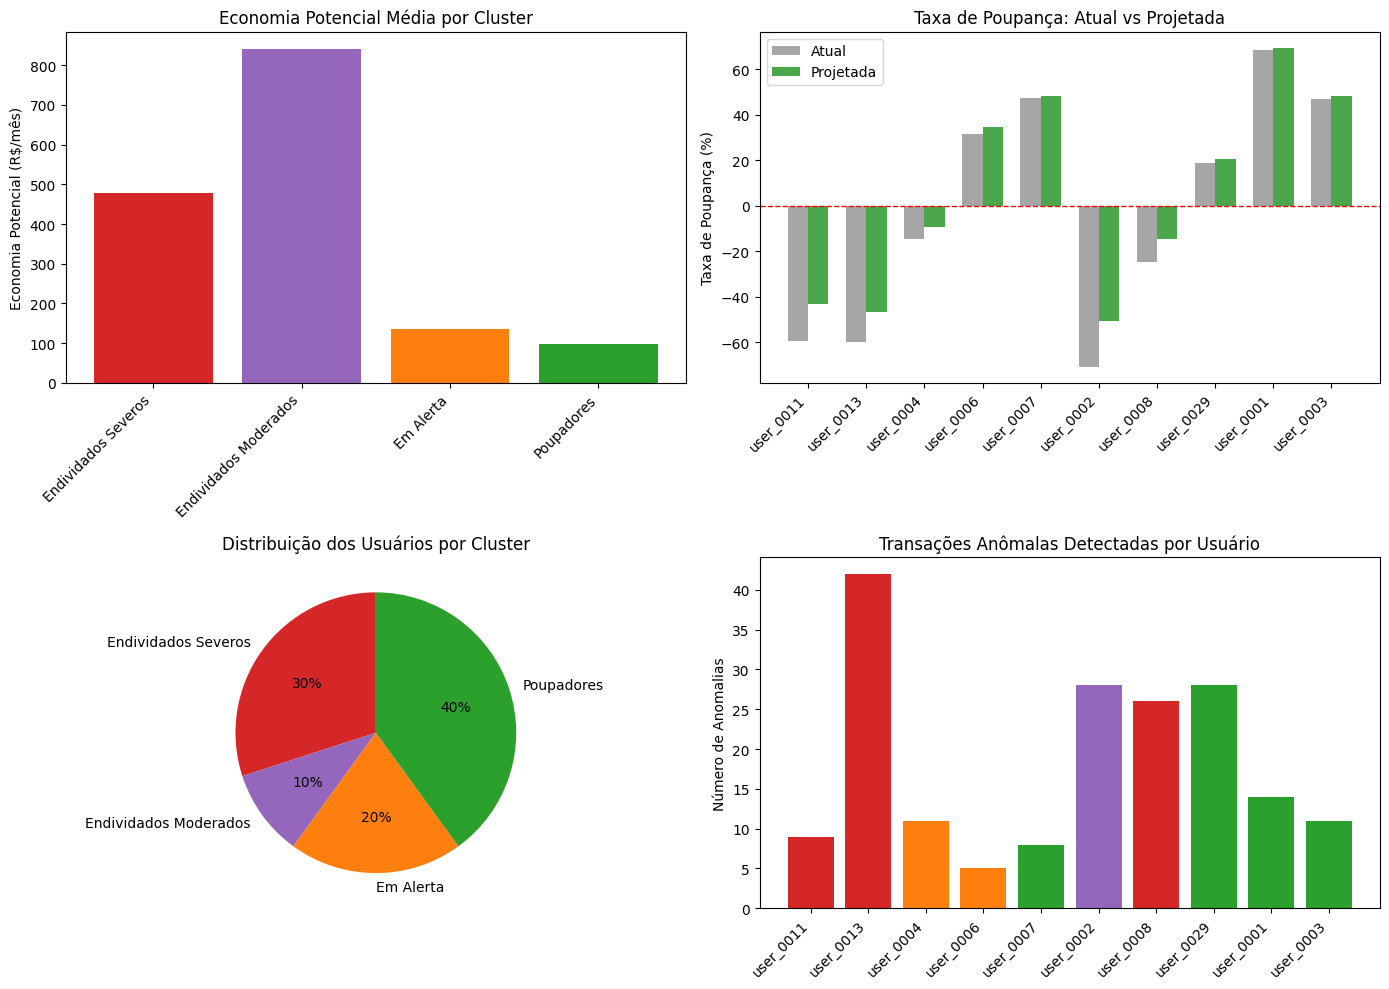

Gráfico salvo: outputs/pipeline_resultados_teste.png


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Economia potencial por cluster
cluster_order = ['Endividados Severos', 'Endividados Moderados', 'Em Alerta', 'Poupadores']
colors = ['#d62728', '#9467bd', '#ff7f0e', '#2ca02c']

economia_por_cluster = df_teste.groupby('cluster_nome')['economia_potencial'].mean().reindex(cluster_order)
# Filtrar apenas clusters presentes
mask = ~economia_por_cluster.isna()
economia_present = economia_por_cluster[mask]
colors_present = [colors[i] for i, m in enumerate(mask) if m]

axes[0, 0].bar(range(len(economia_present)), economia_present.values, color=colors_present)
axes[0, 0].set_xticks(range(len(economia_present)))
axes[0, 0].set_xticklabels(economia_present.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Economia Potencial (R$/mês)')
axes[0, 0].set_title('Economia Potencial Média por Cluster')

# 2. Taxa de poupança atual vs projetada
x = range(len(df_teste))
width = 0.35
axes[0, 1].bar([i - width/2 for i in x], df_teste['taxa_poupanca'], width, 
               label='Atual', color='gray', alpha=0.7)
taxa_projetada = df_teste['taxa_poupanca'] + df_teste['pct_economia']
axes[0, 1].bar([i + width/2 for i in x], taxa_projetada, width, 
               label='Projetada', color='green', alpha=0.7)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(df_teste['user_id'], rotation=45, ha='right')
axes[0, 1].set_ylabel('Taxa de Poupança (%)')
axes[0, 1].set_title('Taxa de Poupança: Atual vs Projetada')
axes[0, 1].legend()

# 3. Distribuição por cluster
cluster_counts = df_teste['cluster_nome'].value_counts()
# Usar apenas os clusters presentes
cluster_present_order = [c for c in cluster_order if c in cluster_counts.index]
cluster_counts_ordered = cluster_counts[cluster_present_order]
colors_pie = [colors[cluster_order.index(c)] for c in cluster_present_order]

axes[1, 0].pie(cluster_counts_ordered.values, labels=cluster_counts_ordered.index, colors=colors_pie,
               autopct='%1.0f%%', startangle=90)
axes[1, 0].set_title('Distribuição dos Usuários por Cluster')

# 4. Anomalias por usuário
bar_colors = [CLUSTER_CORES[c] for c in df_teste['cluster']]
axes[1, 1].bar(range(len(df_teste)), df_teste['anomalias'], color=bar_colors)
axes[1, 1].set_xticks(range(len(df_teste)))
axes[1, 1].set_xticklabels(df_teste['user_id'], rotation=45, ha='right')
axes[1, 1].set_ylabel('Número de Anomalias')
axes[1, 1].set_title('Transações Anômalas Detectadas por Usuário')

plt.tight_layout()
plt.savefig('../outputs/pipeline_resultados_teste.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/pipeline_resultados_teste.png")

## 9. Salvar Pipeline

In [12]:
# Salvar pipeline completo
pipeline_data = {
    'versao': '1.0',
    'data_criacao': datetime.now().strftime('%Y-%m-%d'),
    'componentes': {
        'kmeans': kmeans_model,
        'scaler_clustering': scaler_clustering,
        'isolation_forest': isolation_forest,
        'scaler_anomalias': scaler_anomalias
    },
    'configuracoes': {
        'features_clustering': FEATURES_CLUSTERING,
        'cluster_names': CLUSTER_NAMES,
        'cluster_prioridades': CLUSTER_PRIORIDADES
    },
    'stats_categoria': stats_categoria.to_dict(),
    'regras_recomendacao': regras_recomendacao
}

joblib.dump(pipeline_data, '../models/pipeline_completo.pkl')

print("Pipeline salvo: models/pipeline_completo.pkl")

Pipeline salvo: models/pipeline_completo.pkl


In [13]:
# Salvar resultados dos testes
df_teste.to_csv('../outputs/pipeline_teste_resultados.csv', index=False)
print("Resultados salvos: outputs/pipeline_teste_resultados.csv")

Resultados salvos: outputs/pipeline_teste_resultados.csv


In [14]:
# Salvar configuração do pipeline
config_pipeline = {
    'versao': '1.0',
    'data_criacao': datetime.now().strftime('%Y-%m-%d'),
    'descricao': 'Pipeline integrado Economiza+ MVP',
    'componentes': {
        'clustering': {
            'modelo': 'K-means',
            'arquivo': 'kmeans_best.pkl',
            'scaler': 'scaler.pkl',
            'features': FEATURES_CLUSTERING,
            'clusters': 4
        },
        'recomendacoes': {
            'tipo': 'Regras por cluster',
            'arquivo': 'recomendacoes_regras.json',
            'total_regras': 8
        },
        'anomalias': {
            'modelo': 'IsolationForest',
            'arquivo': 'isolation_forest.pkl',
            'scaler': 'scaler_anomalias.pkl',
            'features': ['feat_valor_norm', 'feat_ratio_mediana']
        }
    },
    'arquivos': {
        'pipeline_completo': 'pipeline_completo.pkl',
        'resultados_teste': 'outputs/pipeline_teste_resultados.csv',
        'visualizacao': 'outputs/pipeline_resultados_teste.png'
    },
    'funcao_principal': 'analisar_usuario(user_id) -> Dict'
}

with open('../models/config_pipeline.json', 'w', encoding='utf-8') as f:
    json.dump(config_pipeline, f, indent=2, ensure_ascii=False)

print("Configuração salva: models/config_pipeline.json")

Configuração salva: models/config_pipeline.json


## 10. Exemplo de Uso do Pipeline Carregado

In [15]:
# Demonstrar como carregar e usar o pipeline
print("="*70)
print("EXEMPLO: CARREGAR E USAR O PIPELINE")
print("="*70)

print("""
# Código para usar o pipeline em outro notebook/script:

import joblib
import pandas as pd

# Carregar pipeline
pipeline_data = joblib.load('models/pipeline_completo.pkl')

# Carregar dados
transacoes = pd.read_csv('data/raw/transacoes.csv')

# Instanciar pipeline (usando a classe EconomizaPipeline)
pipeline = EconomizaPipeline(
    kmeans_model=pipeline_data['componentes']['kmeans'],
    scaler_clustering=pipeline_data['componentes']['scaler_clustering'],
    regras_recomendacao=pipeline_data['regras_recomendacao'],
    isolation_forest=pipeline_data['componentes']['isolation_forest'],
    scaler_anomalias=pipeline_data['componentes']['scaler_anomalias'],
    stats_categoria=pd.DataFrame(pipeline_data['stats_categoria'])
)

# Analisar usuário
resultado = pipeline.analisar_usuario('user_0001', transacoes)
print(resultado['resumo'])
""")

EXEMPLO: CARREGAR E USAR O PIPELINE

# Código para usar o pipeline em outro notebook/script:

import joblib
import pandas as pd

# Carregar pipeline
pipeline_data = joblib.load('models/pipeline_completo.pkl')

# Carregar dados
transacoes = pd.read_csv('data/raw/transacoes.csv')

# Instanciar pipeline (usando a classe EconomizaPipeline)
pipeline = EconomizaPipeline(
    kmeans_model=pipeline_data['componentes']['kmeans'],
    scaler_clustering=pipeline_data['componentes']['scaler_clustering'],
    regras_recomendacao=pipeline_data['regras_recomendacao'],
    isolation_forest=pipeline_data['componentes']['isolation_forest'],
    scaler_anomalias=pipeline_data['componentes']['scaler_anomalias'],
    stats_categoria=pd.DataFrame(pipeline_data['stats_categoria'])
)

# Analisar usuário
resultado = pipeline.analisar_usuario('user_0001', transacoes)
print(resultado['resumo'])



## 11. Checklist e Resumo Final

In [16]:
# Checklist Dia 12
print("\n" + "="*70)
print("CHECKLIST DIA 12")
print("="*70)
print("\n[x] Carregar todos os artefatos (modelos, scalers, regras)")
print("[x] Criar classe EconomizaPipeline")
print("[x] Implementar calcular_features_usuario()")
print("[x] Implementar classificar_cluster()")
print("[x] Implementar gerar_recomendacoes()")
print("[x] Implementar detectar_anomalias()")
print("[x] Implementar analisar_usuario() - função principal")
print("[x] Criar função wrapper simplificada")
print("[x] Testar com 10 usuários de diferentes clusters")
print("[x] Gerar visualizações dos resultados")
print("[x] Salvar pipeline: models/pipeline_completo.pkl")
print("[x] Salvar configuração: models/config_pipeline.json")
print("\n>>> DIA 12 CONCLUÍDO!")


CHECKLIST DIA 12

[x] Carregar todos os artefatos (modelos, scalers, regras)
[x] Criar classe EconomizaPipeline
[x] Implementar calcular_features_usuario()
[x] Implementar classificar_cluster()
[x] Implementar gerar_recomendacoes()
[x] Implementar detectar_anomalias()
[x] Implementar analisar_usuario() - função principal
[x] Criar função wrapper simplificada
[x] Testar com 10 usuários de diferentes clusters
[x] Gerar visualizações dos resultados
[x] Salvar pipeline: models/pipeline_completo.pkl
[x] Salvar configuração: models/config_pipeline.json

>>> DIA 12 CONCLUÍDO!


In [17]:
# Resumo Final
print("\n" + "="*70)
print("RESUMO FINAL - DIA 12 - PIPELINE INTEGRADO")
print("="*70)

print(f"\nPipeline Economiza+ MVP")
print(f"\nComponentes integrados:")
print(f"  1. Classificação de perfil (K-means, 4 clusters)")
print(f"  2. Sistema de recomendações (8 regras, 2 por cluster)")
print(f"  3. Detecção de anomalias (Isolation Forest)")

print(f"\nFunção principal:")
print(f"  analisar_usuario(user_id) -> Dict")
print(f"  Retorna: perfil, financeiro, recomendações, economia, anomalias, resumo")

print(f"\nTeste realizado com {len(usuarios_teste)} usuários:")
for cluster in sorted(df_teste['cluster'].unique()):
    count = (df_teste['cluster'] == cluster).sum()
    nome = CLUSTER_NAMES[cluster]
    print(f"  - Cluster {cluster} ({nome}): {count} usuários")

print(f"\nArquivos gerados:")
print("  - models/pipeline_completo.pkl")
print("  - models/config_pipeline.json")
print("  - outputs/pipeline_teste_resultados.csv")
print("  - outputs/pipeline_resultados_teste.png")

print(f"\nPróximo passo (Dia 13): Demonstração e Testes")


RESUMO FINAL - DIA 12 - PIPELINE INTEGRADO

Pipeline Economiza+ MVP

Componentes integrados:
  1. Classificação de perfil (K-means, 4 clusters)
  2. Sistema de recomendações (8 regras, 2 por cluster)
  3. Detecção de anomalias (Isolation Forest)

Função principal:
  analisar_usuario(user_id) -> Dict
  Retorna: perfil, financeiro, recomendações, economia, anomalias, resumo

Teste realizado com 10 usuários:
  - Cluster 0 (Endividados Severos): 3 usuários
  - Cluster 1 (Em Alerta): 2 usuários
  - Cluster 2 (Endividados Moderados): 1 usuários
  - Cluster 3 (Poupadores): 4 usuários

Arquivos gerados:
  - models/pipeline_completo.pkl
  - models/config_pipeline.json
  - outputs/pipeline_teste_resultados.csv
  - outputs/pipeline_resultados_teste.png

Próximo passo (Dia 13): Demonstração e Testes
